In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import string, os

In [ ]:
observationDir = "/content/gdrive/MyDrive/Colab Notebooks/Samsung"
data_dir = os.path.join(observationDir, "data")
checkpoint_dir = os.path.join(observationDir, "checkpoints")
model_dir = os.path.join(observationDir, "models")
resource_dir = os.path.join(observationDir, "resources")
output_dir = os.path.join(observationDir, "output")

In [ ]:
observationFile = os.path.join(data_dir, "events_2.txt")
keras_file = os.path.join(model_dir, "events_model.h5")


In [ ]:
# set seeds for reproducability
import tensorflow as tf
from numpy.random import seed

tf.random.set_seed(2)
seed(1)

In [ ]:
class Config:
    # define the data file name
    DATA_FNAME = observationFile
    
    # define the batch size
    BATCH_SIZE = 5
    
    # define the encoder configurations
    EMBEDDING_DIM = 256
    RNN_UNITS = 1024

    # define the training configurations
    EPOCHS = 50
    LR_START = 1e-4
    LR_MAX = 1e-3
    WARMUP_PERCENT = 0.15

    # define the patience for early stopping
    PATIENCE = 3
    
    # define the output path
    OUTPUT_PATH = output_dir

config = Config()

In [ ]:
def load_data(fname):
    with open(fname, "r") as f:
      contents = f.readlines()

    source = []
    target = []
    inps = []

    max_length = 187
    for c in contents:
        inp = c.rstrip()
        if len(inp) == 0:
          continue
        inp = "%" + inp + ";"
        res = [inp[i:i + max_length] for i in range(0, len(inp), max_length)]
        for i in res:
          src = i[:-1]
          tgt = i[1:]
          
          source.append(src)
          target.append(tgt)
        inps.append(inp)


    # return the list of source and target sentences
    return (source, target, inps, max_length)

In [ ]:
# load data from disk
print(f"[INFO] loading data from {config.DATA_FNAME}...")
(source, target, inp, max_length) = load_data(fname=config.DATA_FNAME)
print(len(source), len(target), max_length)

[INFO] loading data from /content/gdrive/MyDrive/Colab Notebooks/Samsung/data/events_2.txt...
274255 274255 187


In [ ]:
train = (source, target)

In [ ]:
print(target[0])

Patient/1001 1 0 {"code": {"coding": [{"code": "93830-8", "display": "Light sleep duration", "system": "<URI_loinc>"}]}, "valuePeriod": {"<D>": 2520}};


In [ ]:
# create source text processing layer and adapt on the training
# source sentences
print("[INFO] performing text vectorization...")

sourceTextProcessor = tf.keras.layers.TextVectorization(
    max_tokens=max_length,
    standardize=None,
    split = "character",
    pad_to_max_tokens = True
)
sourceTextProcessor.adapt(inp)

[INFO] performing text vectorization...


In [ ]:
source_vector = sourceTextProcessor(source)
target_vector = sourceTextProcessor(target)

In [ ]:
def make_dataset(splits, batchSize, train=False):
    # build a TensorFlow dataset from the input and target
    (source, target) = splits 
    dataset = tf.data.Dataset.from_tensor_slices((source_vector, target_vector))

    # check if this is the training dataset, if so, shuffle, batch,
    # and prefetch it
    if train:
        dataset = (
            dataset
            .batch(batchSize)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )

    # otherwise, just batch the dataset
    else:
        dataset = (
            dataset
            .batch(batchSize)
            .prefetch(tf.data.experimental.AUTOTUNE)
        )

    # return the dataset
    return dataset

In [ ]:
# build the TensorFlow data datasets of the respective data splits
print("[INFO] building TensorFlow Data input pipeline...")
trainDs = make_dataset(splits=train, batchSize=config.BATCH_SIZE,
    train=True)

[INFO] building TensorFlow Data input pipeline...


In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(sourceTextProcessor.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
print(vocab_size)

74


In [ ]:
def eventModel(vocab_size, embedding_dim, rnn_units, batch_size):
  print(vocab_size)
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None], mask_zero=True, name="eventEmbedding"),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform', name="eventGRU_1"),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform', name="eventGRU_2"),
    tf.keras.layers.Dense(vocab_size, name="eventDense")
  ], name="eventModel")
  return model

In [ ]:
print(vocab_size)

74


In [ ]:
model = eventModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size = config.BATCH_SIZE)

74


#### If you have partly trained your model, uncomment the relevant lines and change checkpoint directory, if necessary, to load saved checkpoint weights

In [ ]:
# Find last checkpoint
tf.train.latest_checkpoint(checkpoint_dir)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
for input_example_batch, target_example_batch in trainDs.take(1):
  print(input_example_batch)
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

tf.Tensor(
[[48 34  9  7  6  4 12  7 44 18 19 19 18  3 18  3 19  3 17  2 13  8 10  4
   2  5  3 17  2 13  8 10  6 12 23  2  5  3 42 17  2 13  8 10  4  2  5  3
   2 38 27 26 27 19 45 26  2 14  3  2 10  6 11 32 15  9 20  2  5  3  2 50
   6 23 54  7  3 11 15  4  4 32  3 10 21 30  9  7  6  8 12  2 14  3  2 11
  20 11  7  4 22  2  5  3  2 25 31 35 37 36 15  8  6 12 13 24  2 16 41 16
  14  3  2 33  9 15 21  4 34  4 30  6  8 10  2  5  3 17  2 25 46 24  2  5
   3 28 40 28 19 16 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [48 34  9  7  6  4 12  7 44 18 19 19 18  3 28  3 39 19  3 17  2 13  8 10
   4  2  5  3 17  2 13  8 10  6 12 23  2  5  3 42 17  2 13  8 10  4  2  5
   3  2 50 34 29 18 28 18 18 27 45 40  2 14  3  2 10  6 11 32 15  9 20  2
   5  3  2 50  6 23 54  7  3 11 15  4  4 32  3 10 21 30  9  7  6  8 12  2
  14  3  2 11 20 11  7  4 22  2  5  3  2 25 31 35 37 36 15  8  6 12 13 24
   2 16 41 16 14  3  2 33  9 15 21  4 34  4 

In [ ]:
model.summary()

Model: "eventModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 eventEmbedding (Embedding)  (5, None, 256)            18944     
                                                                 
 eventGRU_1 (GRU)            (5, None, 1024)           3938304   
                                                                 
 eventGRU_2 (GRU)            (5, None, 1024)           6297600   
                                                                 
 eventDense (Dense)          (5, None, 74)             75850     
                                                                 
Total params: 10,330,698
Trainable params: 10,330,698
Non-trainable params: 0
_________________________________________________________________


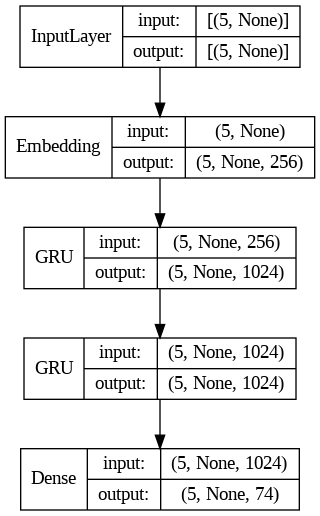

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='modelSummary.png', show_shapes=True, show_layer_names=False)

In [ ]:
# The standard tf.keras.losses.sparse_categorical_crossentropy loss function works in this case 
# because it is applied across the last dimension of the predictions.
 
# Because our model returns logits, we need to set the from_logits flag.
 
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
#loss = MaskedLoss()
 
example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

optimizer =  tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, clipvalue=3.0)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Prediction shape:  (5, 186, 74)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       1.1269708


In [ ]:
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
   filepath=checkpoint_prefix,
   save_weights_only=True)

## Uncomment  the lines below to train the model

In [ ]:
EPOCHS = 20
history = model.fit(trainDs, epochs=EPOCHS, batch_size=config.BATCH_SIZE, shuffle=False, callbacks=[checkpoint_callback])

Epoch 1/20
54851/54851 [==============================] - 1476s 27ms/step - loss: 0.0690 - accuracy: 0.9720
Epoch 2/20
54851/54851 [==============================] - 1467s 27ms/step - loss: 0.0686 - accuracy: 0.9722
Epoch 3/20
54851/54851 [==============================] - 1471s 27ms/step - loss: 0.0683 - accuracy: 0.9723
Epoch 4/20
54851/54851 [==============================] - 1473s 27ms/step - loss: 0.0680 - accuracy: 0.9724
Epoch 5/20
54851/54851 [==============================] - 1472s 27ms/step - loss: 0.0677 - accuracy: 0.9726
Epoch 6/20
54851/54851 [==============================] - 1469s 27ms/step - loss: 0.0673 - accuracy: 0.9728
Epoch 7/20
54851/54851 [==============================] - 1477s 27ms/step - loss: 0.0670 - accuracy: 0.9729
Epoch 8/20
54851/54851 [==============================] - 1474s 27ms/step - loss: 0.0666 - accuracy: 0.9731
Epoch 9/20
54851/54851 [==============================] - 1446s 26ms/step - loss: 0.0662 - accuracy: 0.9733
Epoch 10/20
54851/54851 [===

Epoch 1/20
54851/54851 [==============================] - 3797s 69ms/step - loss: 0.0947 - accuracy: 0.9606
Epoch 2/20
54851/54851 [==============================] - 3805s 69ms/step - loss: 0.0943 - accuracy: 0.9607
Epoch 3/20
54851/54851 [==============================] - 3777s 69ms/step - loss: 0.0941 - accuracy: 0.9607
Epoch 4/20
54851/54851 [==============================] - 3790s 69ms/step - loss: 0.0937 - accuracy: 0.9609
Epoch 5/20
54851/54851 [==============================] - 3820s 70ms/step - loss: 0.0934 - accuracy: 0.9610
Epoch 6/20
54851/54851 [==============================] - 3873s 71ms/step - loss: 0.0930 - accuracy: 0.9611
Epoch 7/20
54851/54851 [==============================] - 3877s 71ms/step - loss: 0.0927 - accuracy: 0.9613
Epoch 8/20
54851/54851 [==============================] - 3872s 71ms/step - loss: 0.0924 - accuracy: 0.9614

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
#plt.plot(history.history['accuracy'])
##plt.plot(history.history['val_accuracy'])
#plt.title('Model Accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['Train', 'Validation'], loc='upper left')
#plt.show()

In [ ]:
# summarize history for loss
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('Model Loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['Train', 'Validation'], loc='upper left')
#plt.show()

In [ ]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='modelSummary.png', show_shapes=True, show_layer_names=True)

2915/2915 [==============================] - 34271s 12s/step - loss: 0.0373 - accuracy: 0.9868

### Here we have trained the model. We now save it.

In [ ]:
model = eventModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size = 1)

74


In [ ]:
# Find last checkpoint
tf.train.latest_checkpoint(checkpoint_dir)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# The standard tf.keras.losses.sparse_categorical_crossentropy loss function works in this case 
# because it is applied across the last dimension of the predictions.
 
# Because our model returns logits, we need to set the from_logits flag.
 
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer =  tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, clipvalue=3.0)

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
print('Saving model to: ', keras_file)
tf.keras.models.save_model(model, keras_file, include_optimizer=True)

Saving model to:  /content/gdrive/MyDrive/Colab Notebooks/Samsung/models_3/events_model.h5


In [ ]:
source_vectorize_layer_model = tf.keras.models.Sequential()
source_vectorize_layer_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
source_vectorize_layer_model.add(sourceTextProcessor)
source_vectorize_layer_model.summary()
source_vectorize_layer_model.save(model_dir + "/sourceTokenLayer")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
